# Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/[2024FL] Reinforcement Learning/Final Project/2 Ethereum.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
1,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
3,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
4,2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1069680000


In [ ]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1979 non-null   object 
 1   Open       1979 non-null   float64
 2   High       1979 non-null   float64
 3   Low        1979 non-null   float64
 4   Close      1979 non-null   float64
 5   Adj Close  1979 non-null   float64
 6   Volume     1979 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 108.4+ KB


In [ ]:
# Verify that the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Feature Engineering: Logarithmic Return, Moving averages, Volatility
df['Log Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1)) # For handling non-stationarity
df['MA 20'] = df['Adj Close'].rolling(window=20).mean()
df['Volatility'] = df['Adj Close'].rolling(window=20).std()

# Lagged Features
for lag in range(1, 6):
    df[f'Lag {lag}'] = df['Close'].shift(lag)

df['Volatility_MA20'] = df['Volatility'] * df['MA 20']

# Market State Classification
def classify_market_state(row):
    if row['Volatility'] < 0.02:
        return 'Low Volatility'
    elif row['Volatility'] < 0.05:
        return 'Medium Volatility'
    else:
        return 'High Volatility'

df['Market State'] = df.apply(classify_market_state, axis=1)

# drop unnecessary/abnormal columns
df.drop(columns=['Adj Close'], inplace=True)
df.dropna(inplace=True)

# deep reinforcement learning is sensitive to number range, so we normalize the data
# Sliding window normalization
def normalize_dynamic_window(data, features, window_size=50):
  normalized_data = data.copy()
  for feature in features:
    normalized_column = f"{feature}_scaled"
    normalized_data[normalized_column] = (
        normalized_data[feature].rolling(window=window_size, min_periods=1).apply(lambda x: ((x.iloc[-1] - x.mean()) / (x.std() + 1e-8))
        if x.std() > 0 else np.nan, raw=False).clip(-3, 3)
        )
  return normalized_data

features_to_normalize = ['Log Return', 'MA 20', 'Volatility']
df = normalize_dynamic_window(df, features=features_to_normalize, window_size=50)

# Define in-sample(2018-2020) and out-of-sample(2021-2022) periods
in_sample = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2020-12-31')]
out_sample = df[(df['Date'] >= '2021-01-01') & (df['Date'] <= '2022-12-31')]
in_sample.reset_index(drop=True, inplace=True)
out_sample.reset_index(drop=True, inplace=True)

In [ ]:
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Log Return,MA 20,Volatility,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Volatility_MA20,Market State,Log Return_scaled,MA 20_scaled,Volatility_scaled
20,2017-11-30,431.214996,465.497009,401.243011,447.114014,1903040000,0.044806,386.698453,62.681287,427.523010,472.902008,480.355011,471.329987,466.276001,24238.756749,High Volatility,0.707107,0.707107,-0.707107
21,2017-12-01,445.209015,472.609009,428.312012,466.540009,1247879936,0.042530,394.291403,62.696023,447.114014,427.523010,472.902008,480.355011,471.329987,24720.502772,High Volatility,0.563666,1.004417,-0.566684
22,2017-12-02,466.851013,476.239014,456.653015,463.449005,943649984,-0.006647,402.068454,61.041859,466.540009,447.114014,427.523010,472.902008,480.355011,24543.006047,High Volatility,-0.023468,1.171539,-1.312777
23,2017-12-03,463.704987,482.813995,451.851990,465.852997,990556992,0.005174,409.525304,59.146294,463.449005,466.540009,447.114014,427.523010,472.902008,24221.904110,High Volatility,0.138129,1.263664,-1.492954
24,2017-12-04,466.053986,474.777008,453.312012,470.204010,1005550016,0.009297,416.153954,58.084210,465.852997,463.449005,466.540009,447.114014,427.523010,24171.973817,High Volatility,0.192713,1.302919,-1.402111


## Data Visualization

In [ ]:
print("In-sample size:", in_sample.shape)
print("Out-of-sample size:", out_sample.shape)

In-sample size: (1096, 19)
Out-of-sample size: (730, 19)


In [ ]:
print(df[['Open', 'High', 'Low', 'Close', 'Volume', 'Log Return', 'MA 20', 'Volatility']].describe())
# should be between 0~1 due to normalization

              Open         High          Low        Close        Volume  \
count  1959.000000  1959.000000  1959.000000  1959.000000  1.959000e+03   
mean   1162.594046  1199.035008  1121.674108  1163.113214  1.278863e+10   
std    1166.625900  1201.989901  1126.044447  1166.162301  1.056553e+10   
min      84.279694    85.342743    82.829887    84.308296  9.436500e+08   
25%     215.771232   221.400665   208.997757   215.969932  5.069084e+09   
50%     603.902039   618.983154   580.628784   605.187012  1.035859e+10   
75%    1775.351074  1817.918396  1710.958801  1775.297363  1.788867e+10   
max    4810.071289  4891.704590  4718.039063  4812.087402  8.448291e+10   

        Log Return        MA 20   Volatility  
count  1959.000000  1959.000000  1959.000000  
mean      0.000762  1156.148598    94.967116  
std       0.050420  1157.929740   107.345435  
min      -0.550732    97.268186     2.494690  
25%      -0.021279   215.872735    15.331580  
50%       0.000806   595.053110    47.7834

In [ ]:
df.to_csv("/content/drive/MyDrive/[2024FL] Reinforcement Learning/Final Project/2 Ethereum_2.csv", index=False)


df_loaded = pd.read_csv("/content/drive/MyDrive/[2024FL] Reinforcement Learning/Final Project/2 Ethereum_2.csv")
print(df_loaded.head())

         Date        Open        High         Low       Close      Volume  \
0  2017-11-30  431.214996  465.497009  401.243011  447.114014  1903040000   
1  2017-12-01  445.209015  472.609009  428.312012  466.540009  1247879936   
2  2017-12-02  466.851013  476.239014  456.653015  463.449005   943649984   
3  2017-12-03  463.704987  482.813995  451.851990  465.852997   990556992   
4  2017-12-04  466.053986  474.777008  453.312012  470.204010  1005550016   

   Log Return       MA 20  Volatility       Lag 1       Lag 2       Lag 3  \
0    0.044806  386.698453   62.681287  427.523010  472.902008  480.355011   
1    0.042530  394.291403   62.696023  447.114014  427.523010  472.902008   
2   -0.006647  402.068454   61.041859  466.540009  447.114014  427.523010   
3    0.005174  409.525304   59.146294  463.449005  466.540009  447.114014   
4    0.009297  416.153954   58.084210  465.852997  463.449005  466.540009   

        Lag 4       Lag 5  Volatility_MA20     Market State  \
0  471.3299

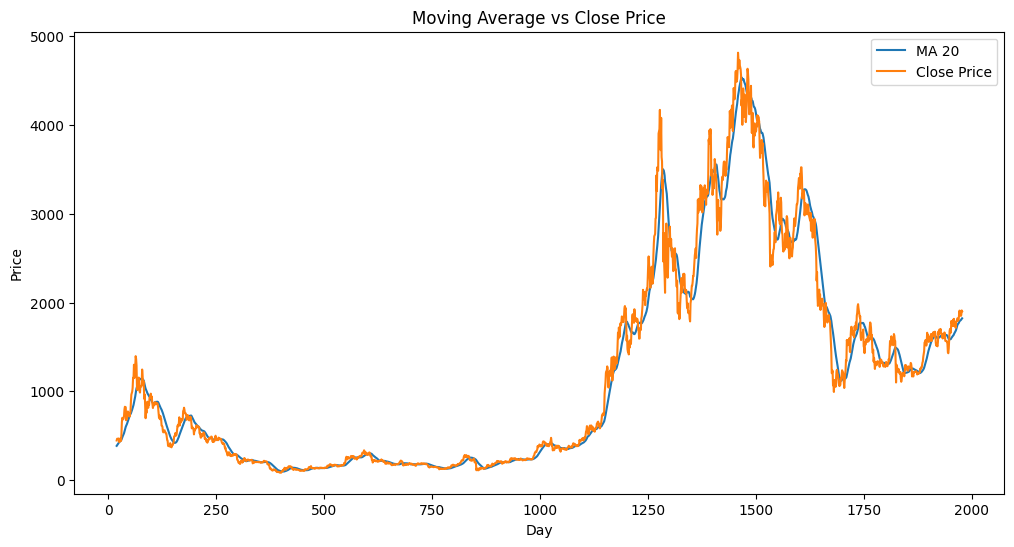

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['MA 20'], label='MA 20')
plt.plot(df['Close'], label='Close Price')
plt.legend()
plt.title('Moving Average vs Close Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

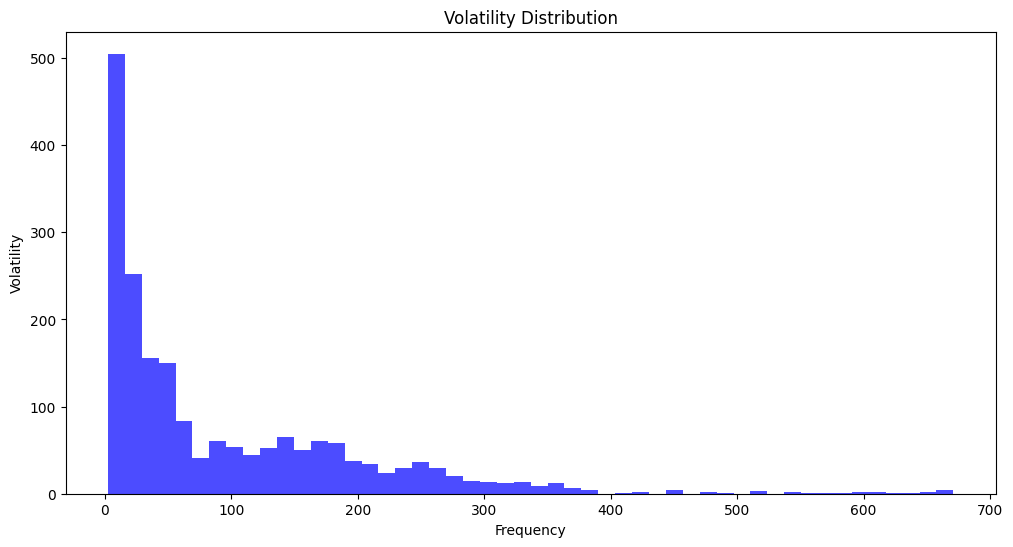

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(df['Volatility'], bins=50, color='blue', alpha=0.7)
plt.title('Volatility Distribution')
plt.xlabel('Frequency')
plt.ylabel('Volatility')
plt.show()

# Environment

In [ ]:
states = ["Low Volatility", "Medium Volatility", "High Volatility"]

action_mapping = {0: "Hold", 1: "Buy", 2: "Sell"}
actions = list(action_mapping.keys())

In [ ]:
def initialize_env(data, initial_balance=10000, transaction_cost=0.001):
    env = {
        'data': data.reset_index(drop=True),
        'n_steps': len(data),
        'initial_balance': initial_balance,
        'transaction_cost': transaction_cost,
        'current_step': 0,
        'balance': initial_balance,
        'holdings': 0,
        'total_value': initial_balance,
        'total_values': [initial_balance],  # Track total values over time
        'returns': [],  # Portfolio returns
        'sharpe_ratios': [],  # Sharpe Ratios
        'done': False
    }
    return env

def reset_env(env):
    env['current_step'] = 0
    env['balance'] = env['initial_balance']
    env['holdings'] = 0
    env['total_value'] = env['initial_balance']
    env['total_values'] = [env['initial_balance']]  # Reset total values
    env['returns'] = []
    env['sharpe_ratios'] = []  # Reset Sharpe Ratios
    env['done'] = False
    return get_observation(env)

def get_observation(env):
    # Select only the scaled columns as features
    numeric_columns = env['data'][['Log Return_scaled', 'MA 20_scaled', 'Volatility_scaled']]
    return numeric_columns.iloc[env['current_step']].values

def render_env(env):
    if len(env['returns']) > 1:
        mean_return = np.mean(env['returns'])  # Cumulative mean return
        volatility = np.std(env['returns']) + 1e-9  # Cumulative volatility
        sharpe_ratio = mean_return / volatility if volatility > 0 else 0
    else:
        sharpe_ratio = 0  # Default Sharpe Ratio

    print(f"Step: {env['current_step']}, Balance: {env['balance']:.2f}, "
          f"Holdings: {env['holdings']:.2f}, Total Value: {env['total_value']:.2f}, "
          f"Sharpe Ratio: {sharpe_ratio:.4f}")

def step_env(env, action):
    # Get current price
    current_price = env['data'].iloc[env['current_step']]['Close']
    previous_value = env['total_value']

    # Take actions: Buy, Sell, or Hold
    if action == 1:  # Buy
        if env['balance'] > 0:
            env['holdings'] += (env['balance'] * (1 - env['transaction_cost'])) / current_price
            env['balance'] = 0
    elif action == 2:  # Sell
        if env['holdings'] > 0:
            env['balance'] += env['holdings'] * current_price * (1 - env['transaction_cost'])
            env['holdings'] = 0

    # Update portfolio value
    env['total_value'] = env['balance'] + env['holdings'] * current_price
    env['total_values'].append(env['total_value'])  # Track total value over time

    # Calculate portfolio return
    portfolio_return = (env['total_value'] - previous_value) / previous_value if previous_value > 0 else 0
    env['returns'].append(portfolio_return)

    # Calculate cumulative Sharpe Ratio
    if len(env['returns']) > 1:
        mean_return = np.mean(env['returns'])
        volatility = np.std(env['returns']) + 1e-9
        sharpe_ratio = mean_return / volatility if volatility > 0 else 0
    else:
        sharpe_ratio = 0

    env['sharpe_ratios'].append(sharpe_ratio)

    # Advance step
    env['current_step'] += 1
    env['done'] = env['current_step'] >= env['n_steps'] - 1

    # Return observation, portfolio reward, sharpe reward, done, and info
    return get_observation(env), portfolio_return, sharpe_ratio, env['done'], {
        "sharpe_ratio": sharpe_ratio,
        "total_value": env['total_value']
    }

def normalize(value, min_val, max_val):
    # Avoid division by zero by ensuring max_val > min_val
    if max_val == min_val:
        return 0  # Neutral value if no variation
    return (value - min_val) / (max_val - min_val) * 2 - 1


In [ ]:
import random
# Test Script: Run One Episode
# Initialize the environment with the given data
env = initialize_env(df, initial_balance=10000, transaction_cost=0.001)

# Reset the environment and get the initial state
state = reset_env(env)

print("Starting one episode...\n")

# Run one episode
while not env['done']:
    # Random action: 0 = Hold, 1 = Buy, 2 = Sell
    action = random.choice([0, 1, 2])

    # Take the step and retrieve metrics
    next_state, portfolio_return, sharpe_reward, done, info = step_env(env, action)

    # Print step-by-step metrics
    print(f"Step: {env['current_step']}, Action: {['Hold', 'Buy', 'Sell'][action]}, "
          f"Sharpe Ratio: {info['sharpe_ratio']:.4f}, "
          f"Total Value: {info['total_value']:.2f}")

    # Update state
    state = next_state

print("\nEpisode finished.")
print(f"Final Total Value: {env['total_value']:.2f}")


Starting one episode...

Step: 1, Action: Sell, Sharpe Ratio: 0.0000, Total Value: 10000.00
Step: 2, Action: Sell, Sharpe Ratio: 0.0000, Total Value: 10000.00
Step: 3, Action: Buy, Sharpe Ratio: -0.7071, Total Value: 9990.00
Step: 4, Action: Buy, Sharpe Ratio: 0.4317, Total Value: 10041.82
Step: 5, Action: Buy, Sharpe Ratio: 0.6826, Total Value: 10135.61
Step: 6, Action: Sell, Sharpe Ratio: -0.0469, Total Value: 9976.39
Step: 7, Action: Hold, Sharpe Ratio: -0.0434, Total Value: 9976.39
Step: 8, Action: Buy, Sharpe Ratio: -0.0592, Total Value: 9966.42
Step: 9, Action: Buy, Sharpe Ratio: 0.3046, Total Value: 10462.50
Step: 10, Action: Sell, Sharpe Ratio: 0.4466, Total Value: 10852.47
Step: 11, Action: Buy, Sharpe Ratio: 0.4160, Total Value: 10841.62
Step: 12, Action: Hold, Sharpe Ratio: 0.4402, Total Value: 12643.52
Step: 13, Action: Buy, Sharpe Ratio: 0.4988, Total Value: 15988.75
Step: 14, Action: Hold, Sharpe Ratio: 0.5496, Total Value: 17248.74
Step: 15, Action: Sell, Sharpe Ratio: 0

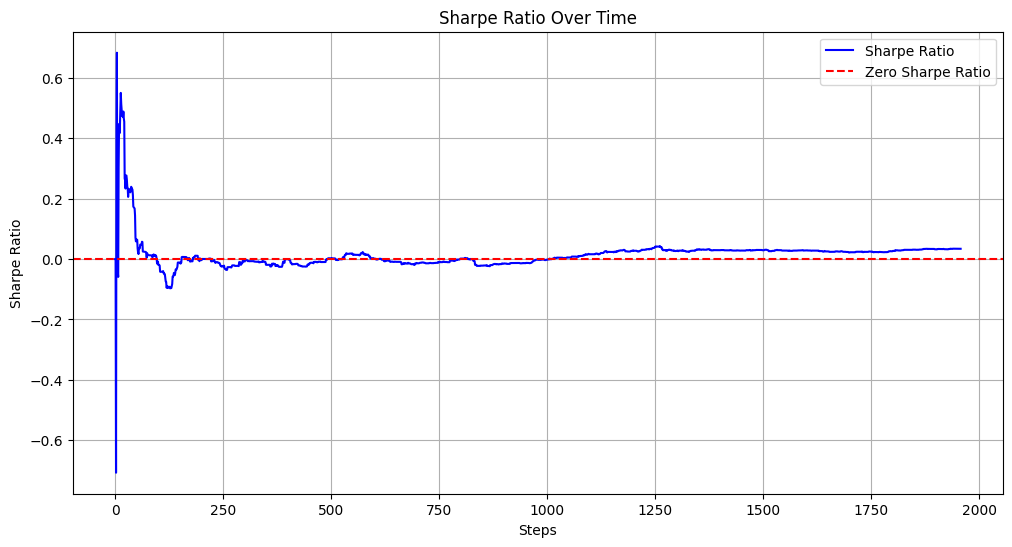

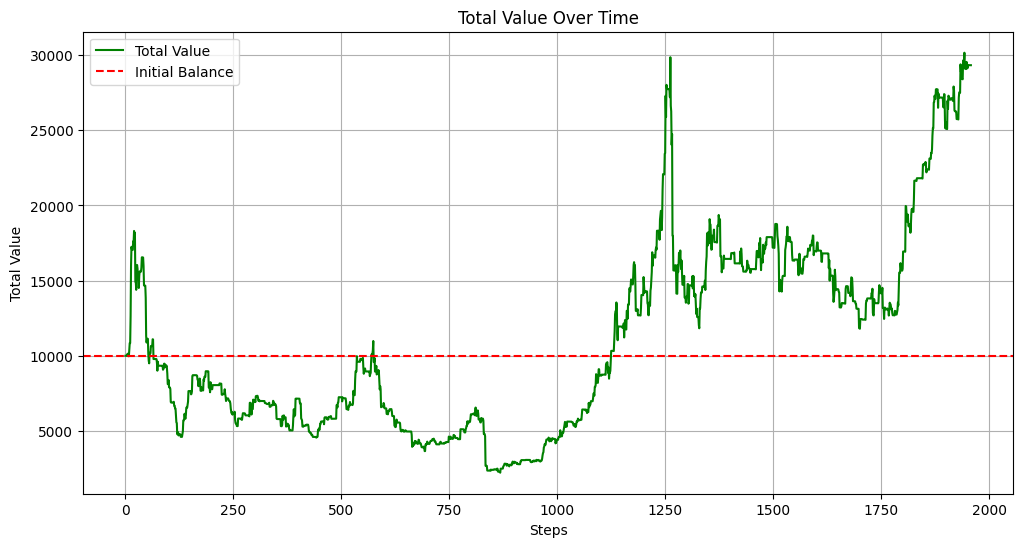

In [ ]:
# Visualize the Sharpe Ratio
sharpe_ratios = env['sharpe_ratios']
plt.figure(figsize=(12, 6))
plt.plot(sharpe_ratios, label='Sharpe Ratio', color='blue')
plt.title('Sharpe Ratio Over Time')
plt.xlabel('Steps')
plt.ylabel('Sharpe Ratio')
plt.axhline(0, color='red', linestyle='--', label='Zero Sharpe Ratio')
plt.legend()
plt.grid()
plt.show()

# Visualize the Total Value
plt.figure(figsize=(12, 6))
plt.plot(env['total_values'], label='Total Value', color='green')
plt.title('Total Value Over Time')
plt.xlabel('Steps')
plt.ylabel('Total Value')
plt.axhline(env['initial_balance'], color='red', linestyle='--', label='Initial Balance')  # Baseline
plt.legend()
plt.grid()
plt.show()

# Deep Q Learing

Second DQN

# Other Approaches

## PPO

### Building Network

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Hyperparameters
learning_rate = 0.0001
gamma = 0.95  # Discount factor
epsilon = 0.1  # Clipping parameter
gae_lambda = 0.97  # GAE lambda
epochs = 10  # PPO update epochs
batch_size = 64
num_episodes = 10
max_steps = 2000
step_patience = 100  # Early stopping patience for steps
patience = 5  # Early stopping patience for episodes

# Define the policy network
def build_policy_network(input_shape, output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# Define the value network
def build_value_network(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

# Initialize networks
state_size = (3,)  # Log Return_scaled, MA 20_scaled, Volatility_scaled
action_size = 3  # Actions: [Hold, Buy, Sell]
policy_network = build_policy_network(state_size, action_size)
value_network = build_value_network(state_size)

# Optimizers
policy_optimizer = tf.keras.optimizers.Adam(learning_rate)
value_optimizer = tf.keras.optimizers.Adam(learning_rate)

# Reward normalization
sharpe_min, sharpe_max = float('inf'), float('-inf')
return_min, return_max = float('inf'), float('-inf')

# Helper function for GAE
def compute_advantages(rewards, values, dones, gamma, gae_lambda):
    advantages = []
    advantage = 0
    for i in reversed(range(len(rewards))):
        td_error = rewards[i] + gamma * values[i + 1] * (1 - dones[i]) - values[i]
        advantage = td_error + gamma * gae_lambda * (1 - dones[i]) * advantage
        advantages.insert(0, advantage)
    return np.array(advantages)

# Initialize metrics storage
episode_sharpe_ratios = []
episode_portfolio_returns = []

### Training Loop

In [ ]:
# Training loop
best_sharpe = -np.inf
early_stop_counter = 0

for episode in range(num_episodes):
    env = initialize_env(in_sample)
    state = get_observation(env)
    states, actions, rewards, dones, log_probs, values = [], [], [], [], [], []
    steps = 0

    while not env['done'] and steps < max_steps:
        state_tensor = tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)

        # Get action probabilities and value
        action_probs = policy_network(state_tensor)
        value = value_network(state_tensor)

        # Sample action
        action = np.random.choice(action_size, p=action_probs.numpy()[0])
        log_prob = tf.math.log(action_probs[0, action])

        # Take a step
        next_state, portfolio_reward, sharpe_reward, done, _ = step_env(env, action)
        states.append(state)
        actions.append(action)
        rewards.append(portfolio_reward)
        dones.append(done)
        log_probs.append(log_prob)
        values.append(value.numpy()[0, 0])

        state = next_state
        steps += 1

    # Add final value for GAE
    final_value = value_network(tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)).numpy()[0, 0]
    values.append(final_value)

    # Compute advantages
    advantages = compute_advantages(rewards, values, dones, gamma, gae_lambda)
    returns = advantages + values[:-1]

    # Convert to tensors
    states = tf.convert_to_tensor(np.array(states), dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    returns = tf.convert_to_tensor(returns, dtype=tf.float32)
    advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
    old_log_probs = tf.convert_to_tensor(log_probs, dtype=tf.float32)

    # PPO update
    for _ in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            # Policy network update
            action_probs = policy_network(states)
            action_prob = tf.reduce_sum(action_probs * tf.one_hot(actions, action_size), axis=1)
            log_prob = tf.math.log(action_prob)
            ratio = tf.exp(log_prob - old_log_probs)
            clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)
            policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))

            # Value network update
            value_predictions = value_network(states)
            value_loss = tf.reduce_mean((returns - tf.squeeze(value_predictions))**2)

        # Apply gradients
        policy_gradients = tape.gradient(policy_loss, policy_network.trainable_variables)
        value_gradients = tape.gradient(value_loss, value_network.trainable_variables)
        policy_optimizer.apply_gradients(zip(policy_gradients, policy_network.trainable_variables))
        value_optimizer.apply_gradients(zip(value_gradients, value_network.trainable_variables))

    # Calculate episode-level Sharpe Ratio and Portfolio Return
    total_portfolio_return = np.sum(rewards)
    mean_return = np.mean(rewards)
    std_dev = np.std(rewards) + 1e-9
    sharpe_ratio = mean_return / std_dev

    # Append metrics for visualization
    episode_sharpe_ratios.append(sharpe_ratio)
    episode_portfolio_returns.append(total_portfolio_return)

    print(f"Episode {episode + 1}/{num_episodes}, Portfolio Return: {total_portfolio_return:.2f}%, "
          f"Sharpe Ratio: {sharpe_ratio:.4f}, Best Sharpe: {best_sharpe:.4f}")

Episode 1/10, Portfolio Return: 0.94%, Sharpe Ratio: 0.0254, Best Sharpe: -inf
Episode 2/10, Portfolio Return: 0.96%, Sharpe Ratio: 0.0247, Best Sharpe: -inf
Episode 3/10, Portfolio Return: 0.11%, Sharpe Ratio: 0.0028, Best Sharpe: -inf
Episode 4/10, Portfolio Return: 0.52%, Sharpe Ratio: 0.0139, Best Sharpe: -inf
Episode 5/10, Portfolio Return: 0.62%, Sharpe Ratio: 0.0152, Best Sharpe: -inf
Episode 6/10, Portfolio Return: 0.74%, Sharpe Ratio: 0.0184, Best Sharpe: -inf
Episode 7/10, Portfolio Return: -0.33%, Sharpe Ratio: -0.0088, Best Sharpe: -inf
Episode 8/10, Portfolio Return: -0.04%, Sharpe Ratio: -0.0010, Best Sharpe: -inf
Episode 9/10, Portfolio Return: 0.02%, Sharpe Ratio: 0.0006, Best Sharpe: -inf
Episode 10/10, Portfolio Return: 0.20%, Sharpe Ratio: 0.0051, Best Sharpe: -inf


### Test phase

In [ ]:
# Testing phase
test_env = initialize_env(out_sample)
test_state = get_observation(test_env)
test_rewards = []

while not test_env['done']:
    state_tensor = tf.convert_to_tensor(test_state.reshape(1, -1), dtype=tf.float32)
    action_probs = policy_network(state_tensor)
    action = np.argmax(action_probs.numpy()[0])
    next_state, portfolio_reward, _, _, _ = step_env(test_env, action)
    test_rewards.append(portfolio_reward)
    test_state = next_state

# Calculate testing metrics
test_portfolio_return = np.sum(test_rewards)
mean_return = np.mean(test_rewards)
std_dev = np.std(test_rewards) + 1e-9
test_sharpe_ratio = mean_return / std_dev

print(f"Testing Complete: Total Portfolio Return: {test_portfolio_return:.2f}%, Sharpe Ratio: {test_sharpe_ratio:.4f}")

Testing Complete: Total Portfolio Return: 1.68%, Sharpe Ratio: 0.0477


### Data visualization for performance metircs

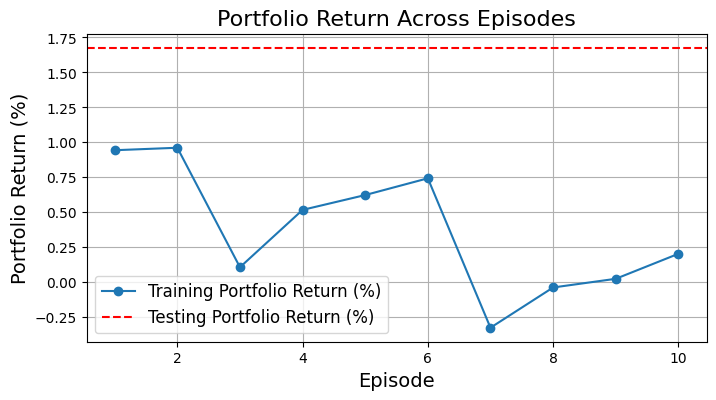

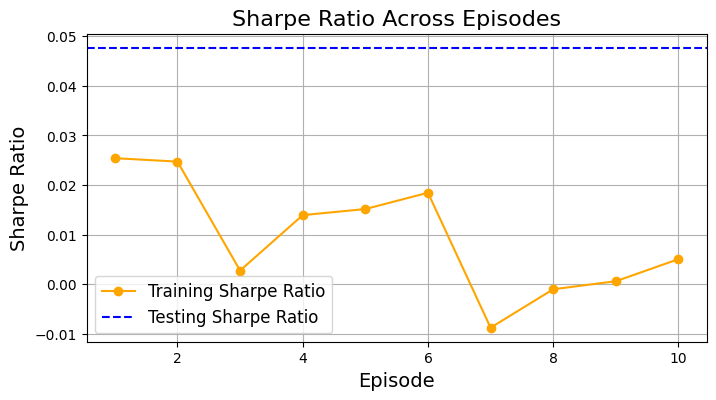

In [ ]:
# Visualization for Portfolio Returns
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(episode_portfolio_returns) + 1), episode_portfolio_returns, marker='o', label='Training Portfolio Return (%)')
plt.axhline(y=test_portfolio_return, color='red', linestyle='--', label='Testing Portfolio Return (%)')
plt.title("Portfolio Return Across Episodes", fontsize=16)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Portfolio Return (%)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Visualization for Sharpe Ratios
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(episode_sharpe_ratios) + 1), episode_sharpe_ratios, marker='o', color='orange', label='Training Sharpe Ratio')
plt.axhline(y=test_sharpe_ratio, color='blue', linestyle='--', label='Testing Sharpe Ratio')
plt.title("Sharpe Ratio Across Episodes", fontsize=16)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sharpe Ratio", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

## A2C

### Model Definition

In [ ]:
# Hyperparameters
learning_rate = 0.0001
gamma = 0.95  # Discount factor
gae_lambda = 0.95  # GAE lambda
num_episodes = 10
max_steps = 2000
batch_size = 64  # Number of steps for gradient updates
entropy_coeff = 0.01  # Entropy regularization coefficient

# Define the policy network
def build_policy_network(input_shape, output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# Define the value network
def build_value_network(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

# Initialize networks
state_size = (3,)  # Log Return_scaled, MA 20_scaled, Volatility_scaled
action_size = 3  # Actions: [Hold, Buy, Sell]
policy_network = build_policy_network(state_size, action_size)
value_network = build_value_network(state_size)

# Optimizers
policy_optimizer = tf.keras.optimizers.Adam(learning_rate)
value_optimizer = tf.keras.optimizers.Adam(learning_rate)

# Training and testing metrics storage
episode_sharpe_ratios = []
episode_portfolio_returns = []

# Helper function to compute advantages
def compute_advantages(rewards, values, gamma):
    advantages = []
    advantage = 0
    for i in reversed(range(len(rewards))):
        td_error = rewards[i] + gamma * values[i + 1] - values[i]
        advantage = td_error + gamma * advantage
        advantages.insert(0, advantage)
    return np.array(advantages)


### Training the A2C model

In [ ]:
# Training loop
for episode in range(num_episodes):
    env = initialize_env(in_sample)
    state = get_observation(env)
    states, actions, rewards, values, log_probs = [], [], [], [], []
    steps = 0

    while not env['done'] and steps < max_steps:
        state_tensor = tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)

        # Predict action probabilities and value
        action_probs = policy_network(state_tensor)
        value = value_network(state_tensor)

        # Sample an action
        action = np.random.choice(action_size, p=action_probs.numpy()[0])
        log_prob = tf.math.log(action_probs[0, action])

        # Take the step
        next_state, portfolio_reward, _, done, _ = step_env(env, action)
        states.append(state)
        actions.append(action)
        rewards.append(portfolio_reward)
        values.append(value.numpy()[0, 0])
        log_probs.append(log_prob)

        state = next_state
        steps += 1

    # Add the final value
    final_value = value_network(tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)).numpy()[0, 0]
    values.append(final_value)

    # Compute advantages
    advantages = compute_advantages(rewards, values, gamma)

    # Convert to tensors
    states = tf.convert_to_tensor(np.array(states), dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
    log_probs = tf.convert_to_tensor(log_probs, dtype=tf.float32)
    returns = tf.convert_to_tensor(advantages + values[:-1], dtype=tf.float32)

    # Compute policy loss
    with tf.GradientTape() as policy_tape:
        action_probs = policy_network(states)
        action_prob = tf.reduce_sum(action_probs * tf.one_hot(actions, action_size), axis=1)
        entropy_loss = -tf.reduce_mean(tf.reduce_sum(action_probs * tf.math.log(action_probs + 1e-9), axis=1))
        policy_loss = -tf.reduce_mean(log_probs * advantages) - entropy_coeff * entropy_loss

    # Compute value loss
    with tf.GradientTape() as value_tape:
        value_predictions = value_network(states)
        value_loss = tf.reduce_mean((returns - tf.squeeze(value_predictions))**2)

    # Apply gradients
    policy_gradients = policy_tape.gradient(policy_loss, policy_network.trainable_variables)
    value_gradients = value_tape.gradient(value_loss, value_network.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_gradients, policy_network.trainable_variables))
    value_optimizer.apply_gradients(zip(value_gradients, value_network.trainable_variables))

    # Calculate episode-level metrics
    total_portfolio_return = np.sum(rewards)
    mean_return = np.mean(rewards)
    std_dev = np.std(rewards) + 1e-9
    sharpe_ratio = mean_return / std_dev

    # Store metrics for visualization
    episode_sharpe_ratios.append(sharpe_ratio)
    episode_portfolio_returns.append(total_portfolio_return)

    print(f"Episode {episode + 1}/{num_episodes}, Portfolio Return: {total_portfolio_return:.2f}%, "
          f"Sharpe Ratio: {sharpe_ratio:.4f}")


Episode 1/10, Portfolio Return: -0.07%, Sharpe Ratio: -0.0017
Episode 2/10, Portfolio Return: -1.49%, Sharpe Ratio: -0.0445
Episode 3/10, Portfolio Return: -0.12%, Sharpe Ratio: -0.0033
Episode 4/10, Portfolio Return: -0.75%, Sharpe Ratio: -0.0203
Episode 5/10, Portfolio Return: -0.45%, Sharpe Ratio: -0.0115
Episode 6/10, Portfolio Return: 1.07%, Sharpe Ratio: 0.0297
Episode 7/10, Portfolio Return: 0.89%, Sharpe Ratio: 0.0229
Episode 8/10, Portfolio Return: 0.87%, Sharpe Ratio: 0.0239
Episode 9/10, Portfolio Return: 0.10%, Sharpe Ratio: 0.0026
Episode 10/10, Portfolio Return: 0.55%, Sharpe Ratio: 0.0154


### Testing the A2C Model

In [ ]:
# Testing phase
test_env = initialize_env(out_sample)
test_state = get_observation(test_env)
test_rewards = []

while not test_env['done']:
    state_tensor = tf.convert_to_tensor(test_state.reshape(1, -1), dtype=tf.float32)
    action_probs = policy_network(state_tensor)
    action = np.argmax(action_probs.numpy()[0])
    next_state, portfolio_reward, _, _, _ = step_env(test_env, action)
    test_rewards.append(portfolio_reward)
    test_state = next_state

# Calculate testing metrics
test_portfolio_return = np.sum(test_rewards)
mean_return = np.mean(test_rewards)
std_dev = np.std(test_rewards) + 1e-9
test_sharpe_ratio = mean_return / std_dev

print(f"Testing Complete: Total Portfolio Return: {test_portfolio_return:.2f}%, Sharpe Ratio: {test_sharpe_ratio:.4f}")


Testing Complete: Total Portfolio Return: 1.09%, Sharpe Ratio: 0.0613


### Data Visualization

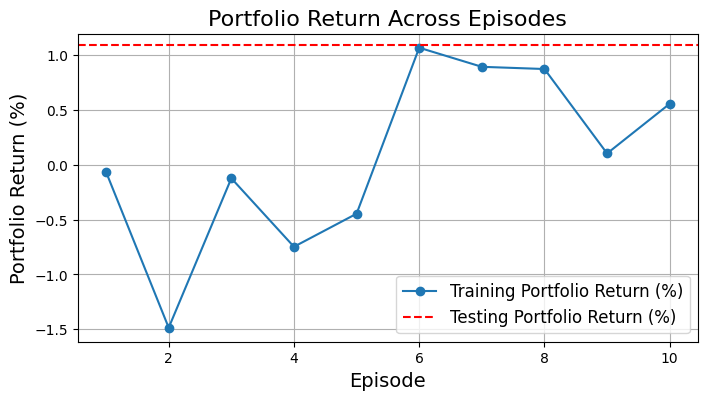

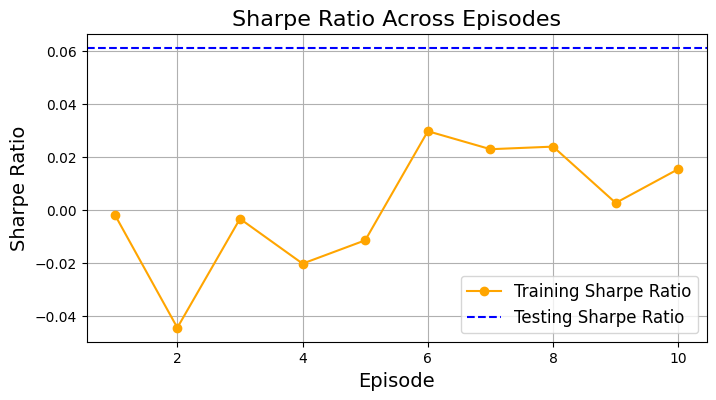

In [ ]:
# Visualization for Portfolio Returns
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(episode_portfolio_returns) + 1), episode_portfolio_returns, marker='o', label='Training Portfolio Return (%)')
plt.axhline(y=test_portfolio_return, color='red', linestyle='--', label='Testing Portfolio Return (%)')
plt.title("Portfolio Return Across Episodes", fontsize=16)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Portfolio Return (%)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Visualization for Sharpe Ratios
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(episode_sharpe_ratios) + 1), episode_sharpe_ratios, marker='o', color='orange', label='Training Sharpe Ratio')
plt.axhline(y=test_sharpe_ratio, color='blue', linestyle='--', label='Testing Sharpe Ratio')
plt.title("Sharpe Ratio Across Episodes", fontsize=16)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sharpe Ratio", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()